In [42]:
from hypersurface import *
import sympy as sp
from pprint import pprint
from scipy.optimize import minimize
from sympy.utilities.iterables import flatten
import math

In [43]:
z0, z1, z2, z3, z4= sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5
HS = Hypersurface(Z, f, 100)

In [44]:
HS.set_k(3)
ns = HS.n_sections

In [45]:
# holomorphic=True by default
factor = (HS.integrate(lambda patch, point: patch.omega_omegabar(point), numerical=True) / \
          HS.integrate(lambda patch, point: patch.num_FS_volume_form('identity', point), numerical=True)).real

The factor can be a build-in attribute and calculated patchwise. Design a function HS.calculate_factor() and call it before num_eta()

In [46]:
def flat_to_matrix(g_flat):
    #g_real = g_flat[:len(g_flat)//2].reshape(ns, ns)
    #g_imag = g_flat[len(g_flat)//2:].reshape(ns, ns)
    g_real = g_flat[:len(g_flat)//2]
    g_imag = g_flat[len(g_flat)//2:]
    tri_real, tri_imag = np.zeros((ns, ns)), np.zeros((ns, ns))
    tri_real[np.tril_indices(ns)] = g_real
    tri_imag[np.tril_indices(ns)] = g_imag
    g_matrix = tri_real + 1j * tri_imag
    return g_matrix

In [47]:
def integration(g_flat):    
    g = flat_to_matrix(g_flat)
    h = g*np.conj(g.transpose())
    integration = HS.integrate(lambda patch, point, h_matrix=h: 
                                np.absolute(patch.num_eta(h_matrix, point)*factor - 1).real, 
                                holomorphic=True, numerical=True)
    integration = integration.real
    print(integration)
    return integration

The first matrix is the real part and second is the imaginary part.

In [48]:
#g0 = np.concatenate((np.ones(ns**2), np.ones(ns**2)),axis=None)*math.sqrt(1/2)
#g0 = np.concatenate((np.identity(ns), np.identity(ns)), axis=None)*math.sqrt(1/2)
#noise_real = np.tril((2 * np.random.rand(ns,ns) - 1) - 1)
#noise_imag = np.tril((2 * np.random.rand(ns,ns) - 1) - 1)
#noise = np.concatenate((noise_real, noise_imag), axis=None)*0.2
#g0 = g0 + noise
g0_real = np.identity(ns)*math.sqrt(1/2) + np.tril((2 * np.random.rand(ns,ns) - 1) - 1) * 0.1
g0_imag = np.identity(ns)*math.sqrt(1/2) + np.tril((2 * np.random.rand(ns,ns) - 1) - 1) * 0.1
g0 = np.concatenate((g0_real[np.tril_indices(ns)], g0_imag[np.tril_indices(ns)]))

In [49]:
res = minimize(integration, g0, method='L-BFGS-B',
               options={'iprint':1, 'ftol': 2.220446049250313e-05, 'eps': 1e-03, 'maxiter':10})

0.23468635235152271
0.23466692844838377
0.23468635235152271
0.23469433383608287
0.23468635235152271
0.23468635235152271
0.23466879922140566
0.23468635235152271
0.23468635235152271


KeyboardInterrupt: 

In [46]:
g_minimal = res.x

In [47]:
g = flat_to_matrix(g_minimal)
h_minimal = g*np.conj(g.transpose())

In [48]:
HS.integrate(lambda patch, point, h_matrix='identity': 
                np.absolute(patch.num_eta(h_matrix, point)*factor - 1).real, 
                holomorphic=True, numerical=True)

(0.22012716499866938+0j)

In [49]:
HS.integrate(lambda patch, point, h_matrix=h_minimal: 
                np.absolute(patch.num_eta(h_matrix, point)*factor - 1).real, 
                holomorphic=True, numerical=True)

(0.1023859078867672+0j)

In [50]:
print(h_minimal)

[[ 6.38308619e-01+0.j         -1.97131233e-02-0.00125862j
   1.37082650e-02+0.0062739j  ... -3.06417781e-03-0.0310038j
   2.20669672e-02-0.00332656j  7.71787604e-02+0.01080822j]
 [-1.97131233e-02+0.00125862j  6.88776009e-01+0.j
   8.59543275e-03+0.00049443j ... -1.73184100e-02-0.03030186j
  -6.07185053e-03-0.00149884j  7.38620291e-05+0.00220841j]
 [ 1.37082650e-02-0.0062739j   8.59543275e-03-0.00049443j
   5.74164950e-01+0.j         ...  4.40991407e-04+0.00276224j
   8.17561832e-03+0.0001814j  -3.10395713e-03-0.00117025j]
 ...
 [-3.06417781e-03+0.0310038j  -1.73184100e-02+0.03030186j
   4.40991407e-04-0.00276224j ...  5.77135139e-01+0.j
   6.23431532e-03+0.00300034j  1.16138094e-02-0.00383669j]
 [ 2.20669672e-02+0.00332656j -6.07185053e-03+0.00149884j
   8.17561832e-03-0.0001814j  ...  6.23431532e-03-0.00300034j
   5.97248825e-01+0.j         -1.40591430e-03-0.00199764j]
 [ 7.71787604e-02-0.01080822j  7.38620291e-05-0.00220841j
  -3.10395713e-03+0.00117025j ...  1.16138094e-02+0.0038366

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

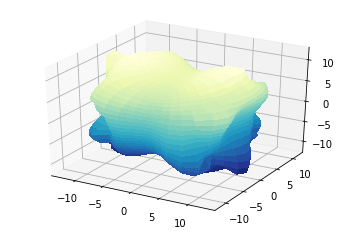

In [52]:
patch = HS.patches[0].patches[0]
theta, phi = np.linspace(0.0001,np.pi+0.0001, 40), np.linspace(0.0001, 2*np.pi+0.0001, 40)
R = []
for j in phi:
    theta_list = []
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i))/(sin(i)*cos(j)) 
        if np.absolute(t) <= 1:
            eta = patch.num_eta(h_minimal, [1, -1, t, 0, -t])
        else:
            eta = patch.num_eta(h_minimal,[1, -1, 1/t, 0, -1/t])
        theta_list.append(eta)
    R.append(theta_list)
R = np.asarray(R)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
Z = R * np.cos(THETA)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)

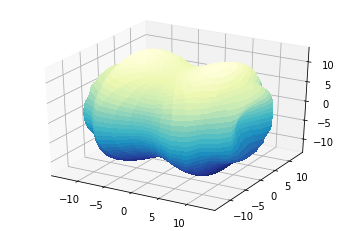

In [35]:
patch = HS.patches[0].patches[0]
theta, phi = np.linspace(0.0001,np.pi+0.0001, 40), np.linspace(0.0001, 2*np.pi+0.0001, 40)
R = []
for j in phi:
    theta_list = []
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i))/(sin(i)*cos(j)) 
        if np.absolute(t) <= 1:
            eta = patch.num_eta('identity', [1, -1, t, 0, -t])
        else:
            eta = patch.num_eta('identity',[1, -1, 1/t, 0, -1/t])
        theta_list.append(eta)
    R.append(theta_list)
R = np.asarray(R)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
Z = R * np.cos(THETA)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)